In [211]:
import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Resize,ToTensor, Normalize, Compose
from torchvision.datasets import ImageFolder
import imageio

import natsort
import os
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [185]:
def visualize(X,Y, index=0):
    """
    Visualizes image
    """
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(X[index][0], cmap='gray')
    plt.title('Image')
    plt.subplot(1,2,2)
    plt.imshow(Y[index][0],cmap='gray')
    plt.title('Segmented Image')
    plt.show()

In [186]:
class Dataset(Dataset):
    
    
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = imageio.imread(img_loc)
        if image.ndim == 3:
            image = 0.2989 * image[:,:,0] + 0.5870 * image[:,:,1] + 0.1140 * image[:,:,2]
        tensor_image = self.transform(image)
        return tensor_image                       
        
        

In [205]:
raw_image_dir = Path("../data/print_only_images/processed")
seg_image_dir = Path("../data/print_only_images/seg_mask")

X = Dataset(raw_image_dir, transform = Compose([ToTensor(), Resize((512,512)), Normalize(mean=(0.5,), std=(0.5,))]))
Y = Dataset(seg_image_dir, transform = Compose([ToTensor(), Resize((512,512)), Normalize(mean=(0.5,), std=(0.5,))]))

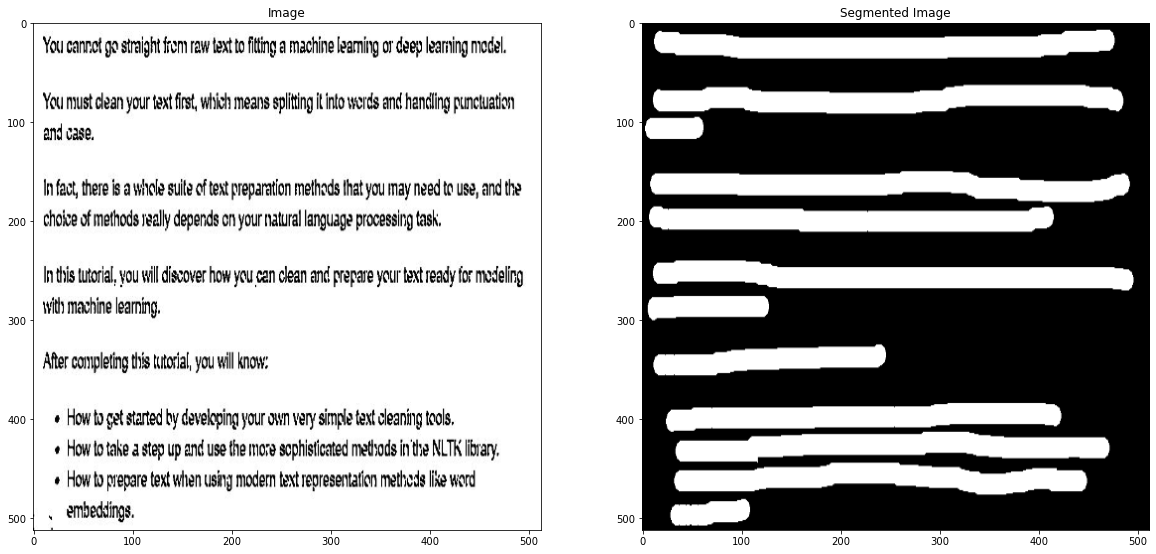

In [206]:
visualize(X, Y, 60)

In [207]:
batch_size = 30
data_loader = DataLoader(X, batch_size, shuffle=True)

## Neural Network

In [218]:
class Unet(nn.Module):
    
    def __init__(self):
        super().__init__() 

        self.resize = Resize(512)
            
        self.conv1 = nn.Conv2d(64, 3, padding=0)
        self.pool1  = nn.MaxPool2d((2,2))
            
        self.conv2 = nn.Conv2d(128, 3, padding=0)
        self.pool2  = nn.MaxPool2d((2,2))
            
        self.conv3 = nn.Conv2d(256, 3, padding=0)
        self.pool3  = nn.MaxPool2d((2,2))
            
        self.conv4 = nn.Conv2d(512, 3, padding=0)
        self.dropout4 = nn.Dropout(0.5)
        self.pool4 = nn.MaxPool2d((2,2))
            
        self.conv5 = nn.Conv2d(512, 3, padding=0)
        self.dropout5 = nn.Dropout(0.5)
                   
        self.conv6_up = nn.Conv2d(512, 2, padding=0)
        self.conv6 = nn.Conv2d(512, 3, padding=0)
        
        self.conv7_up = nn.Conv2d(256, 2, padding=0)
        self.conv7 = nn.Conv2d(256, 3, padding=0)     

        self.conv8_up = nn.Conv2d(128, 2, padding=0)
        self.conv8 = nn.Conv2d(128, 3, padding=0)     

        self.conv9_up = nn.Conv2d(64, 2, padding=0)
        self.conv9 = nn.Conv2d(64, 3, padding=0)

        self.conv10 = nn.Conv2d(2, 3, padding=0)
        
        self.conv_output = nn.Conv2d(1, 1, padding=0)
        
        self.merge = lambda x,y : torch.cat((x, y), 3)
        self.upsample = nn.Upsample((2,2))
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
         
        
            
            
    def foward(self, x):
        
        print(x.shape)
        
        inputs = self.resize(x)
        
        conv1 = self.relu(self.conv1(inputs))
        conv1 = self.relu(self.conv1(conv1))
        pool1 = self.pool1(conv1)
        
        conv2 = self.relu(self.conv2(pool1))
        conv2 = self.relu(self.conv2(conv2))
        pool2 = self.pool2(conv2)
        
        conv3 = self.relu(self.conv3(pool2))
        conv3 = self.relu(self.conv3(conv3))
        pool3 = self.pool3(conv3)
        
        conv4 = self.relu(self.conv4(pool3))
        conv4 = self.relu(self.conv4(conv4))
        drop4 = self.dropout4(conv4)
        pool4 = self.pool4(drop4)
        
        conv5 = self.relu(self.conv5(pool4))
        conv5 = self.relu(self.conv5(conv5))
        drop5 = self.dropout5(conv5)
        
        up6 = self.relu(self.conv6_up(self.upsample(drop5)))
        merge6 = self.merge(drop4, up6)
        conv6 = self.relu(self.conv6(merge6))
        conv6 = self.relu(self.conv6(conv6))
        
        up7 = self.relu(self.conv7_up(self.upsample(conv6)))
        merge7 = self.merge(conv4, up7)
        conv7 = self.relu(self.conv7(merge7))
        conv7 = self.relu(self.conv7(conv7))
        
        up8 = self.relu(self.conv8_up(self.upsample(conv7)))
        merge8 = self.merge(conv2, up8)
        conv8 = self.relu(self.conv8(merge8))
        conv8 = self.relu(self.conv8(conv8))
        
        up9 = self.relu(self.conv9_up(self.upsample(conv8)))
        merge9 = self.merge(conv1, up9)
        conv9 = self.relu(self.conv9(merge9))
        conv9 = self.relu(self.conv9(conv9))
        
        conv10 = self.relu(self.conv10(conv9))
        
        output = self.sigmoid(self.conv_output(conv10))
        
        
        return output

def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('nn.ReLU'))
        nn.init.zeros_(m.bias)

model.apply(weight_init)

Unet(
  (resize): Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)
)

In [217]:
model = Unet()

TypeError: Conv2d.__init__() missing 1 required positional argument: 'kernel_size'

In [203]:
model.foward(X[0][0])

ValueError: Input and output must have the same number of spatial dimensions, but got input with with spatial dimensions of [1058] and output size of [512, 512]. Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.